# NN on time series
Using previously discussed methods, we will ask a NN to predict forecast

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import linregress

In [136]:
def plot_graph(x, y, type="", info="", ylim=None, no_fit=False):
    plt.plot(x, y, 'b')
    plt.title(type)

    if no_fit == False:
        res = linregress(x,y)
        fit_line = res.intercept + res.slope * x
        plt.plot(x, fit_line, 'r', linestyle='--')
        plt.legend([info, 'fit line (Trend)'])

    plt.ylabel('data')
    plt.xlabel('time')
    if ylim is not None:
        plt.ylim(bottom=ylim)
    plt.grid(True)

    plt.show()

In [137]:
def multi_plot_graph(x, y, type="", info="", ylim=None, no_fit=False):
    for y_i in y:
        plt.plot(x, y_i)
    
    plt.title(type)
    
    plt.ylabel('data')
    plt.xlabel('time')
    if ylim is not None:
        plt.ylim(bottom=ylim)
    
    plt.grid(True)
    plt.show()

## Data gathering

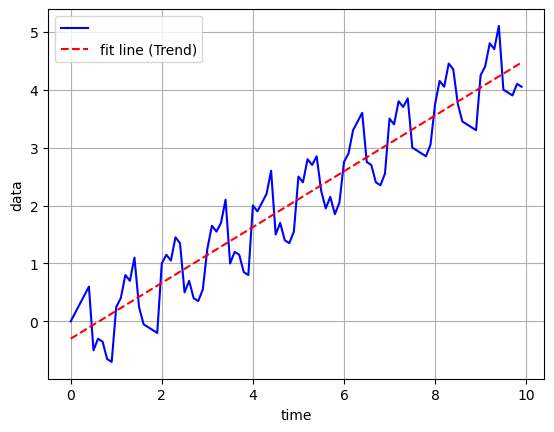

In [138]:
def trend(time, slope):
    return time * slope

def seasonality(time, period):
    time = (time % period) / period
    return np.where(time < 0.5, time, -time)

def noise(time, ampl):
    return np.random.randint(-ampl,ampl, len(time))

t = np.arange(0, 10, 0.1)
signal = trend(t, 0.5) + seasonality(t, 1) + 0.25 * noise(t, 1)

plot_graph(t, signal)


Removing all trend & seasonality

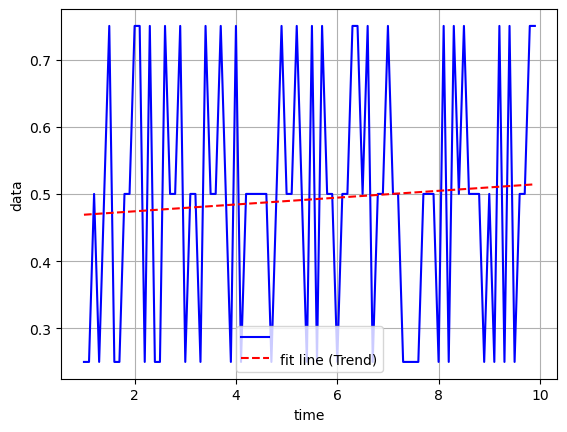

In [139]:
diff = np.zeros(len(t))
diff[10:] = signal[10:] - signal[:-10]
plot_graph(t[10:], diff[10:])

## Splitting dataset

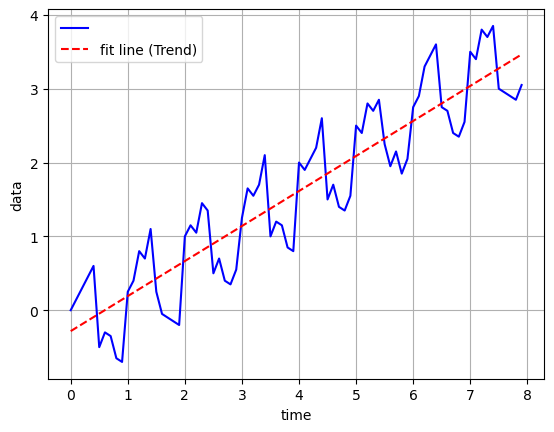

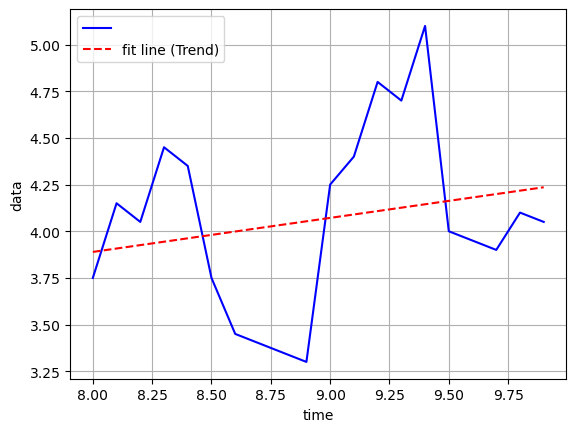

In [140]:
SPLIT_TIME = 80
x_train = signal[:SPLIT_TIME]
t_train = t[:SPLIT_TIME]

x_valid = signal[SPLIT_TIME:]
t_valid = t[SPLIT_TIME:]

plot_graph(t_train, x_train)
plot_graph(t_valid, x_valid)

## Dataset Generation

In [141]:
WINDOW_SIZE = 10
BATCH_SIZE = 32
SHUFFLE_BUFFER = 256
EPOCHS = 100

In [142]:
# Converts numpy array to training data
train_data = tf.data.Dataset.from_tensor_slices(x_train)

train_data = tf.data.Dataset.window(train_data, WINDOW_SIZE+1, 1, drop_remainder=True)
'''Flattening'''
train_data = train_data.flat_map(lambda x: x.batch(BATCH_SIZE+1))

# Split data into training & validation
train_data = train_data.map(lambda x: (x[:-1], x[-1]))
'''Shuffling'''
train_data = train_data.shuffle(SHUFFLE_BUFFER)
'''Batching'''
train_data = train_data.batch(BATCH_SIZE).prefetch(1)

In [143]:
for example in train_data.take(1):
    x, y = example
    print(x.shape, y.shape)

(32, 10) (32,)


## Model building

In [144]:
layer0 = tf.keras.layers.Dense(1, input_shape=(WINDOW_SIZE,))
model = tf.keras.Sequential([
    layer0
])

print(model.summary())
print(layer0.get_weights())

Model: "sequential_7"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
[array([[ 0.2307738 ],
       [ 0.07247835],
       [-0.3622239 ],
       [-0.59096515],
       [ 0.6777305 ],
       [-0.3122589 ],
       [-0.47392142],
       [ 0.44483048],
       [ 0.48257738],
       [ 0.42963904]], dtype=float32), array([0.], dtype=float32)]


In [145]:
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=SGD(learning_rate=1e-2, momentum=0.9),
    loss='mse'
)

## Model Training

In [146]:
model.fit(train_data, epochs=EPOCHS)

Epoch 1/100


3/3 [==============================] - 0s 8ms/step - loss: 0.7775
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 1.1023
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 0.5526
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 0.2508
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 0.2695
Epoch 6/100
3/3 [==============================] - 0s 985us/step - loss: 0.1284
Epoch 7/100
3/3 [==============================] - 0s 886us/step - loss: 0.2339
Epoch 8/100
3/3 [==============================] - 0s 863us/step - loss: 0.2175
Epoch 9/100
3/3 [==============================] - 0s 989us/step - loss: 0.2424
Epoch 10/100
3/3 [==============================] - 0s 930us/step - loss: 0.1132
Epoch 11/100
3/3 [==============================] - 0s 897us/step - loss: 0.0889
Epoch 12/100
3/3 [==============================] - 0s 929us/step - loss: 0.0758
Epoch 13/100
3/3 [==============================] - 0s 950u

In [147]:
layer0.get_weights()

[array([[ 0.5390671 ],
        [-0.13394858],
        [ 0.21241497],
        [ 0.09085838],
        [ 0.31440762],
        [-0.35304764],
        [-0.22119467],
        [ 0.16308025],
        [ 0.11800806],
        [ 0.2870303 ]], dtype=float32),
 array([0.30183458], dtype=float32)]

## Model Prediction

In [148]:
# Take a random window from our series and input
single_example = signal[:WINDOW_SIZE]
single_example = np.expand_dims(single_example, axis=0)
single_prediction = model.predict(single_example)[0][0]
actual_value = signal[WINDOW_SIZE]
print('MODEL PREDICTION', single_prediction)
print('ACTUAL VALUE', actual_value)

print('ERROR', tf.keras.metrics.mse([single_prediction], [actual_value]).numpy())


1/1 [==============================] - 0s 28ms/step
MODEL PREDICTION 0.4831753
ACTUAL VALUE 0.25
ERROR 0.05437072403344789


## Model prediction for entire series

In [149]:
forecast = []
for i in range(len(signal) - WINDOW_SIZE):
    window = signal[i:i+WINDOW_SIZE]
    window = np.expand_dims(window, axis=0)
    # Squeeze reduces all useless dimensions to a single value
    w_prediction = model.predict(window).squeeze()
    forecast.append(w_prediction)

forecast = np.array(forecast)

1/1 [==============================] - 0s 9ms/step


(20,)


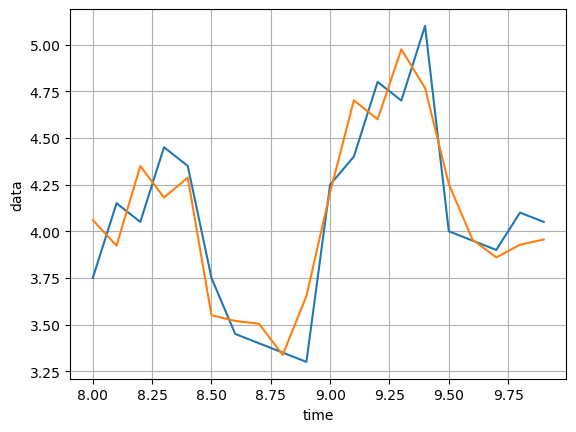

In [150]:
valid_forecast = forecast[-len(x_valid):]
print(valid_forecast.shape)

multi_plot_graph(t_valid, (x_valid, valid_forecast))

In [151]:
from tensorflow.keras.metrics import mse, mae

print(np.sqrt(mse(x_valid, valid_forecast)))
print(mae(x_valid, valid_forecast).numpy())

0.21409926
0.18107055


# Deeper DNN for forecast

## Model creation

In [158]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model2 = Sequential([
    Dense(10, input_shape=(WINDOW_SIZE,), activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 10)                110       
                                                                 
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 


Total params: 231 (924.00 Byte)
Trainable params: 231 (924.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
model2.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss='mse'
)

## Model Training

In [160]:
model2.fit(train_data, epochs=EPOCHS)

Epoch 1/100
3/3 [==============================] - 0s 9ms/step - loss: 6.9380
Epoch 2/100
3/3 [==============================] - 0s 953us/step - loss: 6.7046
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 6.3067
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 5.9027
Epoch 5/100
3/3 [==============================] - 0s 2ms/step - loss: 5.4807
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 5.1134
Epoch 7/100
3/3 [==============================] - 0s 942us/step - loss: 4.8073
Epoch 8/100
3/3 [==============================] - 0s 957us/step - loss: 4.5762
Epoch 9/100
3/3 [==============================] - 0s 947us/step - loss: 4.4037
Epoch 10/100
3/3 [==============================] - 0s 962us/step - loss: 4.2569
Epoch 11/100
3/3 [==============================] - 0s 921us/step - loss: 4.1467
Epoch 12/100
3/3 [==============================] - 0s 997us/step - loss: 4.0497
Epoch 13/100
3/3 [=============================

In [161]:
forecast2 = []

for i in range(len(signal) - WINDOW_SIZE):
    window = signal[i: i+WINDOW_SIZE]
    w_matrix = np.expand_dims(window, axis=0)
    w_prediction = model2.predict(w_matrix)
    w_prediction = w_prediction.squeeze()
    forecast2.append(w_prediction)

forecast2 = np.array(forecast2)

1/1 [==============================] - 0s 9ms/step


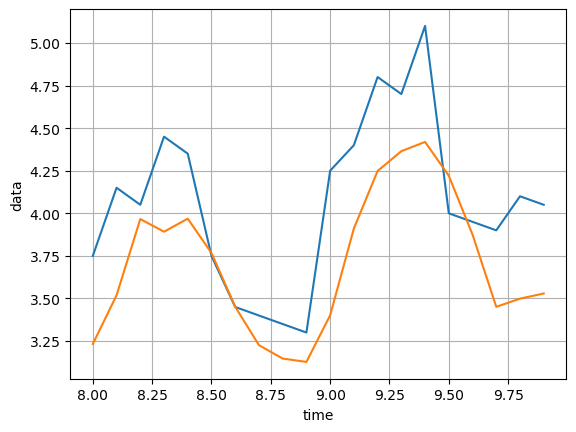

In [162]:
forecast2 = forecast2[-len(x_valid):]
multi_plot_graph(t_valid, (x_valid, forecast2))

In [163]:
from tensorflow.keras.metrics import mse, mae

print(mae(x_valid, forecast2).numpy())
print(np.sqrt(mse(x_valid, forecast2)))

0.3755298
0.44491532


## Tuning the learning rate

In [174]:
model_tune = Sequential([
    Dense(10, activation='relu', input_shape=(WINDOW_SIZE,)),
    Dense(10, activation='relu'),
    Dense(1)
])

In [175]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

In [176]:
model_tune.compile(
    loss='mse',
    optimizer=SGD(momentum=0.9)
)

In [177]:
hist_data = model_tune.fit(train_data, epochs=EPOCHS, callbacks=[lr_scheduler])

Epoch 1/100
3/3 [==============================] - 0s 9ms/step - loss: 1.9148 - lr: 1.0000e-08
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9148 - lr: 1.1220e-08
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9147 - lr: 1.2589e-08
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9147 - lr: 1.4125e-08
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9147 - lr: 1.5849e-08
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9146 - lr: 1.7783e-08
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9145 - lr: 1.9953e-08
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9144 - lr: 2.2387e-08
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9143 - lr: 2.5119e-08
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 1.9142 - lr: 2.8184e-08
Epoch 11/100
3/3 [==============================]

## Plotting learning rate vs epoch

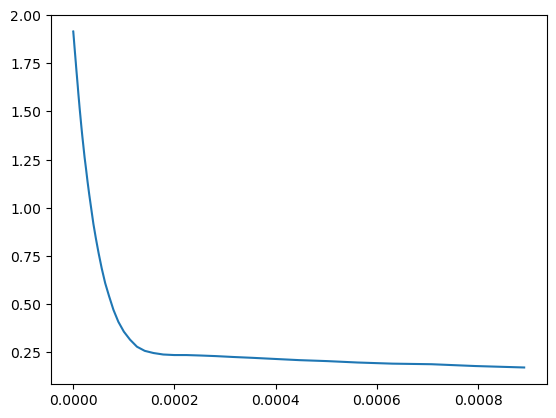

In [178]:
x = 1e-8 * 10 ** (np.arange(100) / 20)
plt.plot(x, hist_data.history['loss'])
plt.show()

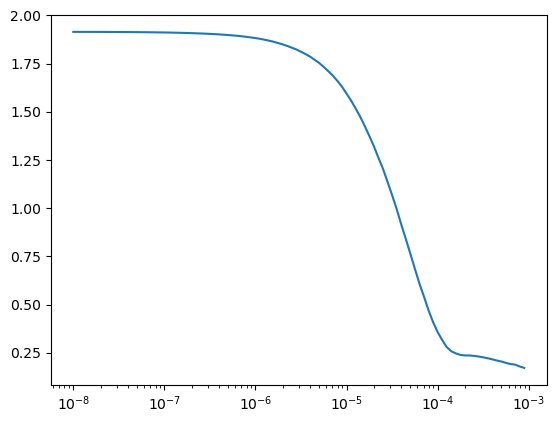

In [181]:
plt.semilogx(x, hist_data.history['loss'])
# plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

## Optimizing model

In [211]:
model_tune2 = Sequential([
    Dense(10, activation='relu', input_shape=(WINDOW_SIZE,)),
    Dense(10, activation='relu'),
    Dense(1)
])

In [212]:
model_tune2.compile(
    loss='mse',
    optimizer=SGD(learning_rate=1e-3, momentum=0)
)

In [213]:
hist_data = model_tune2.fit(train_data, epochs=125, callbacks=[lr_scheduler])

Epoch 1/125
3/3 [==============================] - 0s 9ms/step - loss: 3.1837 - lr: 1.0000e-08
Epoch 2/125
3/3 [==============================] - 0s 1ms/step - loss: 3.1837 - lr: 1.1220e-08
Epoch 3/125
3/3 [==============================] - 0s 1ms/step - loss: 3.1836 - lr: 1.2589e-08
Epoch 4/125
3/3 [==============================] - 0s 924us/step - loss: 3.1836 - lr: 1.4125e-08
Epoch 5/125
3/3 [==============================] - 0s 924us/step - loss: 3.1836 - lr: 1.5849e-08
Epoch 6/125
3/3 [==============================] - 0s 1ms/step - loss: 3.1836 - lr: 1.7783e-08
Epoch 7/125
3/3 [==============================] - 0s 934us/step - loss: 3.1836 - lr: 1.9953e-08
Epoch 8/125
3/3 [==============================] - 0s 959us/step - loss: 3.1835 - lr: 2.2387e-08
Epoch 9/125
3/3 [==============================] - 0s 958us/step - loss: 3.1835 - lr: 2.5119e-08
Epoch 10/125
3/3 [==============================] - 0s 1ms/step - loss: 3.1834 - lr: 2.8184e-08
Epoch 11/125
3/3 [=====================

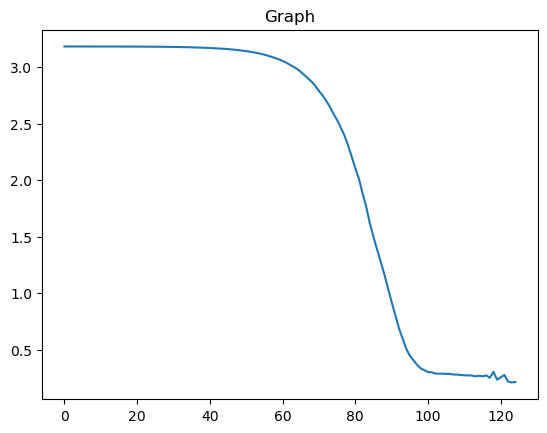

In [214]:
loss = hist_data.history['loss']
plt.plot(range(len(loss)), loss)
plt.title('Graph')
plt.show()

In [215]:
forecast3 = []

for i in range(len(signal) - WINDOW_SIZE):
    window = signal[i: i+WINDOW_SIZE]
    w_matrix = np.expand_dims(window, axis=0)
    w_prediction = model_tune2.predict(w_matrix)
    w_prediction = w_prediction.squeeze()
    forecast3.append(w_prediction)

forecast3 = np.array(forecast3)

1/1 [==============================] - 0s 9ms/step


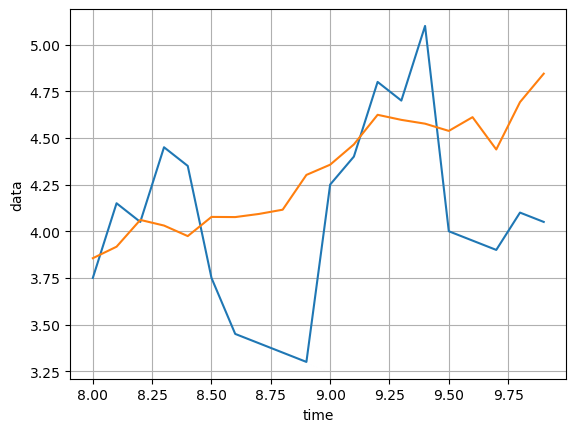

In [216]:
forecast3 = forecast3[-len(x_valid):]
multi_plot_graph(t_valid, (x_valid, forecast3))

In [217]:
from tensorflow.keras.metrics import mse, mae

print(mae(x_valid, forecast3).numpy())
print(np.sqrt(mse(x_valid, forecast3)))

0.43276244
0.51377
